In [ ]:
pip install mord

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.calibration import calibration_curve, CalibrationDisplay
from xgboost import XGBClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from mord import OrdinalRidge, LogisticIT
import numpy as np
from scipy.stats import f_oneway, spearmanr, kruskal, chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:

train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.info()
train_df.head()


Train shape: (59598, 24)
Test shape: (14900, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59598 entries, 0 to 59597
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Employee ID               59598 non-null  int64 
 1   Age                       59598 non-null  int64 
 2   Gender                    59598 non-null  object
 3   Years at Company          59598 non-null  int64 
 4   Job Role                  59598 non-null  object
 5   Monthly Income            59598 non-null  int64 
 6   Work-Life Balance         59598 non-null  object
 7   Job Satisfaction          59598 non-null  object
 8   Performance Rating        59598 non-null  object
 9   Number of Promotions      59598 non-null  int64 
 10  Overtime                  59598 non-null  object
 11  Distance from Home        59598 non-null  int64 
 12  Education Level           59598 non-null  object
 13  Marital Status            5

,Employee ID,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,8410,31,Male,19,Education,5390,Excellent,Medium,Average,2,...,0,Mid,Medium,89,No,No,No,Excellent,Medium,Stayed
1,64756,59,Female,4,Media,5534,Poor,High,Low,3,...,3,Mid,Medium,21,No,No,No,Fair,Low,Stayed
2,30257,24,Female,10,Healthcare,8159,Good,High,Low,0,...,3,Mid,Medium,74,No,No,No,Poor,Low,Stayed
3,65791,36,Female,7,Education,3989,Good,High,High,1,...,2,Mid,Small,50,Yes,No,No,Good,Medium,Stayed
4,65026,56,Male,41,Education,4821,Fair,Very High,Average,0,...,0,Senior,Medium,68,No,No,No,Fair,Medium,Stayed


In [ ]:
#marker column to split later
train_df['is_train'] = 1
test_df['is_train'] = 0

# Combining into one DataFrame
df = pd.concat([train_df, test_df], ignore_index=True)

# Checking shape
print("Combined shape:", df.shape)

Combined shape: (74498, 25)


In [ ]:
rating_mapping = {
    'Low': 1,
    'Below Average': 2,
    'Average': 3,
    'High': 4,
}

df['Performance Rating'] = df['Performance Rating'].map(rating_mapping)

# Verifing conversion
print(df['Performance Rating'].value_counts())


Performance Rating
3    44719
4    14910
2    11139
1     3730
Name: count, dtype: int64


In [ ]:
#Checking for missing values
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])

#Droping rows with missing values
df_cleaned = df.dropna()

#Droping duplicates
df_cleaned = df_cleaned.drop_duplicates()

print("\nAfter cleaning:")
print("Rows:", df_cleaned.shape[0])
print("Columns:", df_cleaned.shape[1])


Missing values:
 Series([], dtype: int64)

After cleaning:
Rows: 74498
Columns: 25


In [ ]:
# Identifying categorical (object) columns except the target and helper columns
categorical_cols = df_cleaned.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['is_train']]  # keep is_train for splitting

print("Categorical columns to encode:", categorical_cols)

# One-hot encode
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

# Confirming shape
print("Shape after encoding:", df_encoded.shape)


Categorical columns to encode: ['Gender', 'Job Role', 'Work-Life Balance', 'Job Satisfaction', 'Overtime', 'Education Level', 'Marital Status', 'Job Level', 'Company Size', 'Remote Work', 'Leadership Opportunities', 'Innovation Opportunities', 'Company Reputation', 'Employee Recognition', 'Attrition']
Shape after encoding: (74498, 42)


In [ ]:

train_df = df_encoded[df_encoded['is_train'] == 1].drop(columns=['is_train'])
test_df = df_encoded[df_encoded['is_train'] == 0].drop(columns=['is_train'])

# Separate features (X) and target (y)
X_train = train_df.drop(columns=['Performance Rating'])
y_train = train_df['Performance Rating']

X_test = test_df.drop(columns=['Performance Rating'])
y_test = test_df['Performance Rating']

# Confirm shapes
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


X_train: (59598, 40)
y_train: (59598,)
X_test: (14900, 40)
y_test: (14900,)


In [ ]:


# working with a smaller sample (to save time)
X_vif = X_train.copy()
X_vif = X_vif.replace({'Yes': 1, 'No': 0})
X_vif = X_vif.apply(pd.to_numeric, errors='coerce')  # force conversion

# Droping any remaining non-numeric cols
X_vif = X_vif.select_dtypes(include=['int64', 'float64'])

# Adding constant and calculate VIF
X_vif_df = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_df.values, i)
                   for i in range(X_vif_df.shape[1])]

# Droping constant and view top correlated
vif_data = vif_data[vif_data["Feature"] != "const"]
vif_data.sort_values(by="VIF", ascending=False).head(15)

,Feature,VIF
3,Years at Company,1.655684
2,Age,1.411247
8,Company Tenure,1.243101
6,Distance from Home,1.000228
1,Employee ID,1.000150
5,Number of Promotions,1.000143
4,Monthly Income,1.000105
7,Number of Dependents,1.000055


scaling

In [ ]:
scaler = StandardScaler()

# Fitting on training, transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
wlb_features = [
    'Work-Life Balance_Fair', 'Work-Life Balance_Good', 'Work-Life Balance_Poor',
    'Job Satisfaction_Low', 'Job Satisfaction_Medium', 'Job Satisfaction_Very High',
    'Overtime_Yes', 'Remote Work_Yes', 'Distance from Home', 'Number of Dependents'
]

# Creating WLB-only feature datasets
X_train_wlb = X_train[wlb_features]
X_test_wlb = X_test[wlb_features]

# Scaling WLB features
scaler_wlb = StandardScaler()
X_train_wlb_scaled = scaler_wlb.fit_transform(X_train_wlb)
X_test_wlb_scaled = scaler_wlb.transform(X_test_wlb)


XGBoost – WLB Features Only (Shifted Labels)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       780
           2       0.11      0.00      0.00      2189
           3       0.60      0.99      0.75      8909
           4       0.12      0.00      0.01      3022

    accuracy                           0.59     14900
   macro avg       0.21      0.25      0.19     14900
weighted avg       0.40      0.59      0.45     14900

Accuracy: 0.5940268456375839


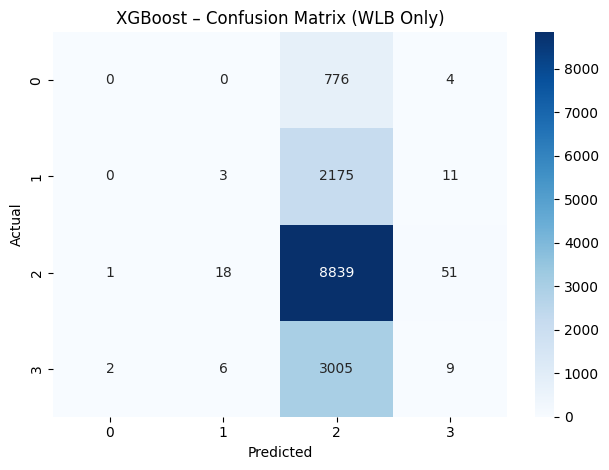

In [ ]:
# Shifting y_train and y_test to be 0-based for XGBoost
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

# Training XGBoost
xgb_wlb = XGBClassifier(random_state=42)
xgb_wlb.fit(X_train_wlb_scaled, y_train_xgb)

# Predicting
y_pred_xgb_wlb = xgb_wlb.predict(X_test_wlb_scaled)

y_pred_xgb_wlb_actual = y_pred_xgb_wlb + 1

# Evaluation
print("XGBoost – WLB Features Only (Shifted Labels)\n")
print(classification_report(y_test, y_pred_xgb_wlb_actual))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb_wlb_actual))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb_wlb_actual), annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost – Confusion Matrix (WLB Only)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Random Forest

Random Forest – WLB Features Only

              precision    recall  f1-score   support

           1       0.05      0.02      0.02       780
           2       0.16      0.09      0.12      2189
           3       0.60      0.77      0.68      8909
           4       0.21      0.13      0.16      3022

    accuracy                           0.50     14900
   macro avg       0.25      0.25      0.24     14900
weighted avg       0.43      0.50      0.45     14900

Accuracy: 0.5028187919463087


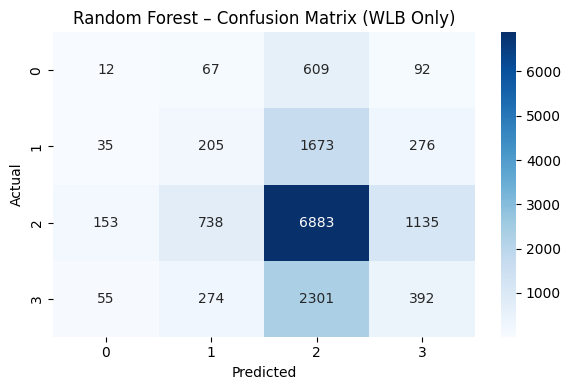

In [ ]:
# Train Random Forest on WLB-only features
rf_wlb = RandomForestClassifier(random_state=42)
rf_wlb.fit(X_train_wlb_scaled, y_train)

# Predict
y_pred_rf_wlb = rf_wlb.predict(X_test_wlb_scaled)

# Evaluation
print("Random Forest – WLB Features Only\n")
print(classification_report(y_test, y_pred_rf_wlb, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_rf_wlb))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf_wlb), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest – Confusion Matrix (WLB Only)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Ordinal Regression

Ordinal Regression – WLB Only

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       780
           2       0.00      0.00      0.00      2189
           3       0.60      1.00      0.75      8909
           4       0.00      0.00      0.00      3022

    accuracy                           0.60     14900
   macro avg       0.15      0.25      0.19     14900
weighted avg       0.36      0.60      0.45     14900

Accuracy: 0.5979194630872483


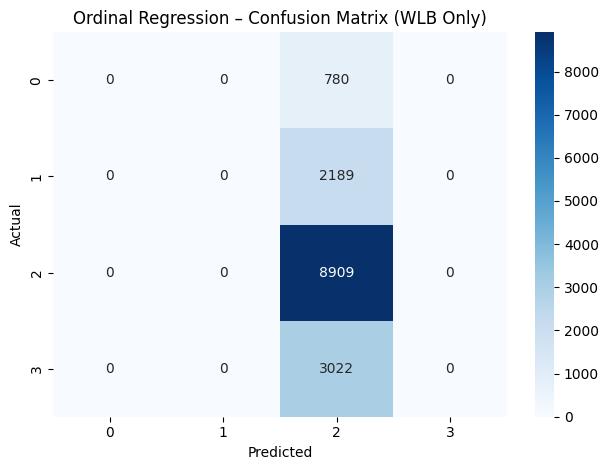

In [ ]:
# Train model
ordinal_wlb = OrdinalRidge()
ordinal_wlb.fit(X_train_wlb_scaled, y_train)

# Predict
y_pred_ordinal_wlb = ordinal_wlb.predict(X_test_wlb_scaled)

# Evaluation
print("Ordinal Regression – WLB Only\n")
print(classification_report(y_test, y_pred_ordinal_wlb, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_ordinal_wlb))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_ordinal_wlb), annot=True, fmt='d', cmap='Blues')
plt.title("Ordinal Regression – Confusion Matrix (WLB Only)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Logistic Regression

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression – WLB Only

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       780
           2       0.00      0.00      0.00      2189
           3       0.60      1.00      0.75      8909
           4       0.00      0.00      0.00      3022

    accuracy                           0.60     14900
   macro avg       0.15      0.25      0.19     14900
weighted avg       0.36      0.60      0.45     14900

Accuracy: 0.5979194630872483


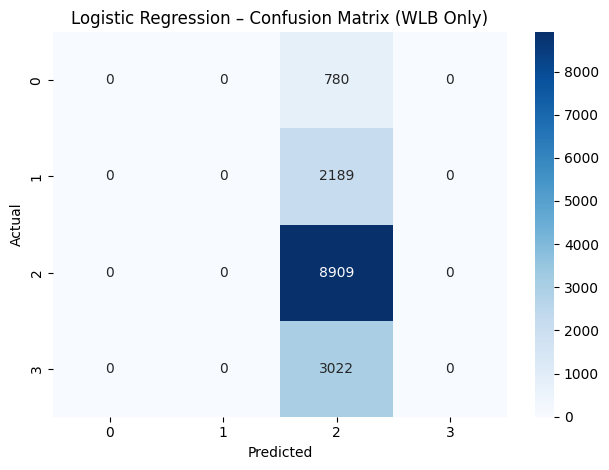

In [ ]:
# Train model
logreg_wlb = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
logreg_wlb.fit(X_train_wlb_scaled, y_train)

# Predict
y_pred_logreg_wlb = logreg_wlb.predict(X_test_wlb_scaled)

# Evaluation
print("Logistic Regression – WLB Only\n")
print(classification_report(y_test, y_pred_logreg_wlb, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_logreg_wlb))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_logreg_wlb), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression – Confusion Matrix (WLB Only)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Linear Regression

 Linear Regression – WLB Only

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       780
           2       0.00      0.00      0.00      2189
           3       0.60      1.00      0.75      8909
           4       0.00      0.00      0.00      3022

    accuracy                           0.60     14900
   macro avg       0.15      0.25      0.19     14900
weighted avg       0.36      0.60      0.45     14900

Accuracy: 0.5979194630872483


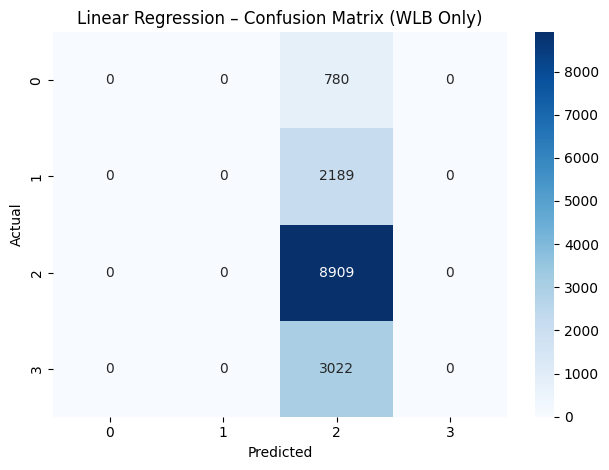

In [ ]:

# Train model
linreg_wlb = LinearRegression()
linreg_wlb.fit(X_train_wlb_scaled, y_train)

# Predict
y_pred_linreg_wlb = linreg_wlb.predict(X_test_wlb_scaled)
y_pred_linreg_wlb_class = np.round(y_pred_linreg_wlb).astype(int)

# Clip to valid class range (1 to 4)
y_pred_linreg_wlb_class = np.clip(y_pred_linreg_wlb_class, y_test.min(), y_test.max())

# Evaluation
print(" Linear Regression – WLB Only\n")
print(classification_report(y_test, y_pred_linreg_wlb_class, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_linreg_wlb_class))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_linreg_wlb_class), annot=True, fmt='d', cmap='Blues')
plt.title("Linear Regression – Confusion Matrix (WLB Only)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Models trained only on WLB features were able to predict "Average" performance well, but performed poorly on other classes.

This implies that Work-Life Balance alone has limited predictive power on performance, especially in distinguishing low or high performers.

scaling

In [ ]:

scaler = StandardScaler()

# Fitting on training, transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model with all features

In [ ]:

# Scale full feature set
scaler_full = StandardScaler()
X_train_scaled = scaler_full.fit_transform(X_train)
X_test_scaled = scaler_full.transform(X_test)


 XGBoost (Full Features)

              precision    recall  f1-score   support

           1       0.05      0.02      0.03       590
           2       0.15      0.04      0.07      1790
           3       0.60      0.87      0.71      7162
           4       0.19      0.06      0.10      2378

    accuracy                           0.54     11920
   macro avg       0.25      0.25      0.22     11920
weighted avg       0.42      0.54      0.46     11920

Accuracy: 0.5435402684563758


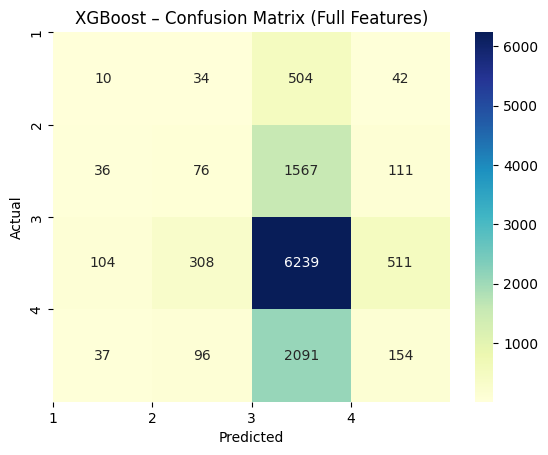

In [ ]:

# Load train and test
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

# Combine for preprocessing
train_df['is_train'] = 1
test_df['is_train'] = 0
combined_df = pd.concat([train_df, test_df], axis=0)

# Label encode the target (Performance Rating)
# Map performance levels to 1–4 scale: Low=1, Below Average=2, Average=3, High=4
combined_df['Performance Rating'] = combined_df['Performance Rating'].map({
    'Low': 1,
    'Below Average': 2,
    'Average': 3,
    'High': 4
})

# Drop non-useful columns
combined_df.drop(['Employee ID'], axis=1, inplace=True)

# One-hot encode categorical variables
combined_df_encoded = pd.get_dummies(combined_df, drop_first=True)

# Split back into train/test
df_train_encoded = combined_df_encoded[combined_df_encoded['is_train'] == 1].drop(columns=['is_train'])
df_test_encoded = combined_df_encoded[combined_df_encoded['is_train'] == 0].drop(columns=['is_train'])

# Define features and target
X_full = df_train_encoded.drop('Performance Rating', axis=1)
y_full = df_train_encoded['Performance Rating']
y_full_xgb = y_full - 1  # XGBoost requires 0-based class labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full_xgb, test_size=0.2, stratify=y_full_xgb, random_state=42
)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost Model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_scaled, y_train_smote)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_actual = y_pred_xgb + 1
y_test_actual = y_test + 1

# Evaluation
print(" XGBoost (Full Features)\n")
print(classification_report(y_test_actual, y_pred_actual))
print("Accuracy:", accuracy_score(y_test_actual, y_pred_actual))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_actual, y_pred_actual), annot=True, fmt='d', cmap='YlGnBu')
plt.title("XGBoost – Confusion Matrix (Full Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0, 1, 2, 3], labels=[1, 2, 3, 4])
plt.yticks(ticks=[0, 1, 2, 3], labels=[1, 2, 3, 4])
plt.show()


Random Forest – Full Features

              precision    recall  f1-score   support

           0       0.14      0.01      0.02       590
           1       0.14      0.03      0.04      1790
           2       0.60      0.93      0.73      7162
           3       0.19      0.03      0.06      2378

    accuracy                           0.57     11920
   macro avg       0.27      0.25      0.21     11920
weighted avg       0.43      0.57      0.46     11920

Accuracy: 0.5715604026845638


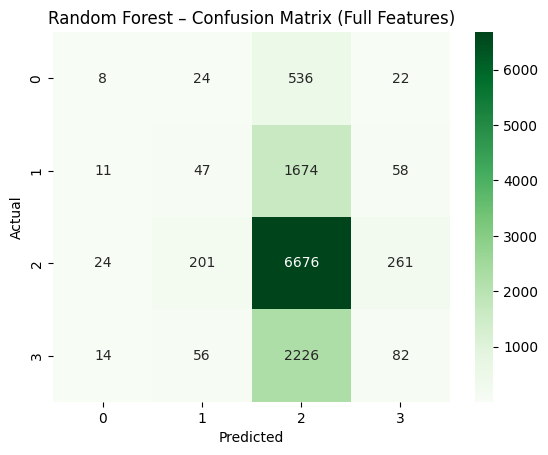

In [ ]:

rf_full = RandomForestClassifier(random_state=42)
rf_full.fit(X_train_scaled, y_train_smote)
y_pred_rf_full = rf_full.predict(X_test_scaled)

print("Random Forest – Full Features\n")
print(classification_report(y_test, y_pred_rf_full, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_rf_full))

sns.heatmap(confusion_matrix(y_test, y_pred_rf_full), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest – Confusion Matrix (Full Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Confirmed labels: [0 1 2 3]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:14:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Train Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.72      0.55     28648
           1       0.44      0.16      0.24     28648
           2       0.59      0.90      0.72     28648
           3       0.40      0.20      0.27     28648

    accuracy                           0.50    114592
   macro avg       0.47      0.50      0.45    114592
weighted avg       0.47      0.50      0.45    114592

Train Accuracy: 0.49776598715442616

Test Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.02      0.03       590
           1       0.14      0.03      0.05      1790
           2       0.60      0.89      0.72      7162
           3       0.18      0.05      0.08      2378

    accuracy                           0.55     11920
   macro avg       0.25      0.25      0.22     11920
weighted avg       0.42      0.55      0.46     11920

Test Accuracy: 0.5531879194630872


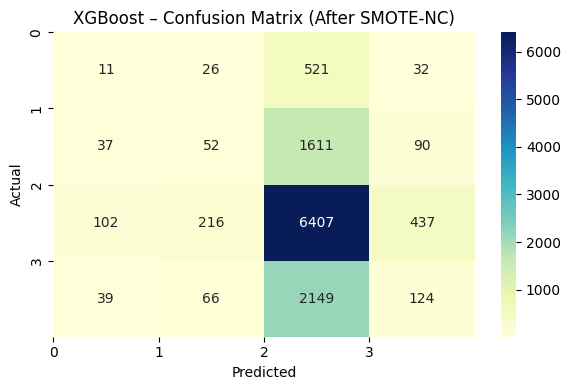

In [ ]:
# Confirm labels again clearly
print("Confirmed labels:", np.unique(y_train_smote))

# XGBoost with regularization (NO shifting)
xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    max_depth=4,
    learning_rate=0.1,
    reg_lambda=1.0,
    reg_alpha=0.5
)

# Fit model directly (NO SHIFTING!)
xgb_model.fit(X_train_scaled, y_train_smote)

# Predict on TRAIN set
y_train_pred = xgb_model.predict(X_train_scaled)
print("Train Classification Report:")
print(classification_report(y_train_smote, y_train_pred))
print("Train Accuracy:", accuracy_score(y_train_smote, y_train_pred))

# Predict on TEST set
y_test_pred = xgb_model.predict(X_test_scaled)
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

# Confusion Matrix (Test)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='YlGnBu')
plt.title("XGBoost – Confusion Matrix (After SMOTE-NC)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0, 1, 2, 3], [0, 1, 2, 3])  # Keep ticks consistent
plt.yticks([0, 1, 2, 3], [0, 1, 2, 3])
plt.tight_layout()
plt.show()


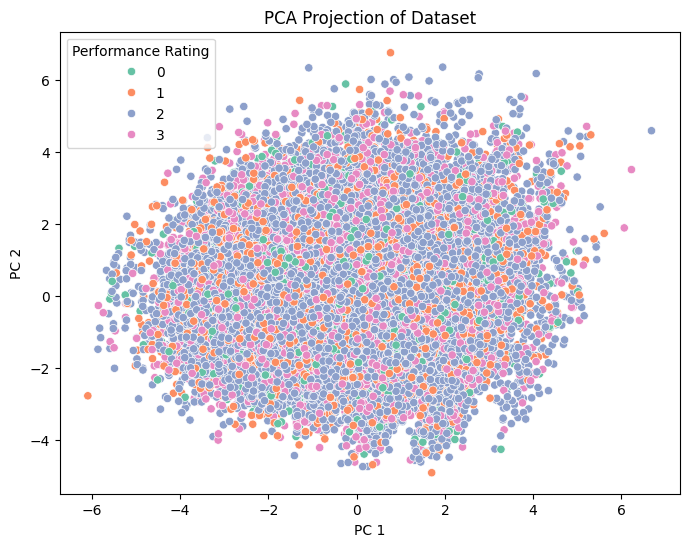

<ipython-input-55-60a3dfc47425>:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x="Importance", y="Feature", palette="viridis")


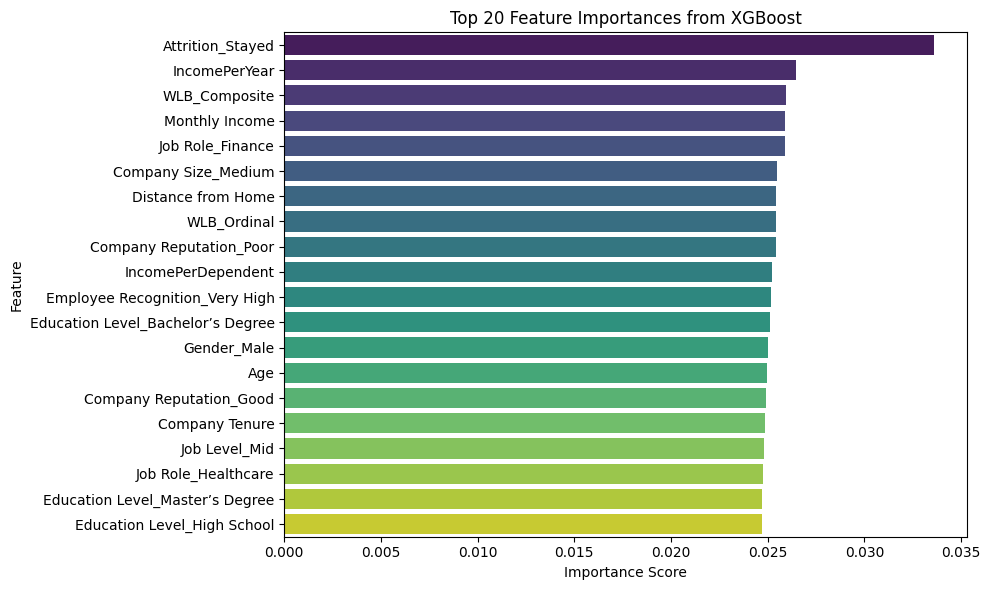

In [ ]:
# Load datasets
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# Add identifier
train_df["is_train"] = 1
test_df["is_train"] = 0
df = pd.concat([train_df, test_df], ignore_index=True)

# Encode target
rating_map = {'Low': 1, 'Below Average': 2, 'Average': 3, 'High': 4}
df["Performance Rating"] = df["Performance Rating"].map(rating_map)

# Drop ID column
df.drop(columns=["Employee ID"], inplace=True)

# Ordinal encoding
df["WLB_Ordinal"] = df["Work-Life Balance"].map({'Poor': 1, 'Fair': 2, 'Good': 3})
df["JobSatisfaction_Ordinal"] = df["Job Satisfaction"].map({'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4})

# Composite WLB score
wlb_features = ['WLB_Ordinal', 'JobSatisfaction_Ordinal', 'Monthly Income',
                'Years at Company', 'Number of Dependents', 'Overtime',
                'Distance from Home', 'Remote Work']
df['IncomePerYear'] = df['Monthly Income'] / (df['Years at Company'] + 1)
df['IncomePerDependent'] = df['Monthly Income'] / (df['Number of Dependents'] + 1)
df['Overtime_and_Remote'] = ((df['Overtime'] == 'Yes') & (df['Remote Work'] == 'Yes')).astype(int)
df['Satisfaction_Interaction'] = df['WLB_Ordinal'] * df['JobSatisfaction_Ordinal']

# Binning distance
bins = [0, 5, 15, df['Distance from Home'].max()+1]
labels = ['Short', 'Medium', 'Long']
df['DistanceBin'] = pd.cut(df['Distance from Home'], bins=bins, labels=labels)
df['DistanceBin_Encoded'] = df['DistanceBin'].map({'Short': 1, 'Medium': 2, 'Long': 3})

# WLB Composite Score
wlb_comp_features = ['WLB_Ordinal', 'JobSatisfaction_Ordinal', 'IncomePerYear',
                     'IncomePerDependent', 'Overtime_and_Remote',
                     'Satisfaction_Interaction', 'DistanceBin_Encoded']
scaler = MinMaxScaler()
df["WLB_Composite"] = scaler.fit_transform(df[wlb_comp_features]).mean(axis=1)

# Drop old WLB columns
df.drop(columns=["Work-Life Balance", "Job Satisfaction", "DistanceBin"], inplace=True)

# One-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)

# Split back into train/test
train_df_encoded = df_encoded[df_encoded["is_train"] == 1].drop(columns=["is_train"])
test_df_encoded = df_encoded[df_encoded["is_train"] == 0].drop(columns=["is_train"])

# Features/target
X = train_df_encoded.drop(columns=["Performance Rating"])
y = train_df_encoded["Performance Rating"] - 1  # 0-3 labels

# Drop NaNs
X = X.dropna()
y = y[X.index]

# PCA
scaler_std = StandardScaler()
X_scaled = scaler_std.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set2')
plt.title("PCA Projection of Dataset")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

# Model-Based Feature Importance (XGBoost)
model = XGBClassifier(random_state=42)
model.fit(X_scaled, y)

importances = model.feature_importances_
feat_names = X.columns
feat_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_df = feat_df.sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df, x="Importance", y="Feature", palette="viridis")
plt.title("Top 20 Feature Importances from XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


🔎 ANOVA Test for WLB Composite Score vs. Performance Rating
F-Statistic: 1.9263
P-Value: 0.1229


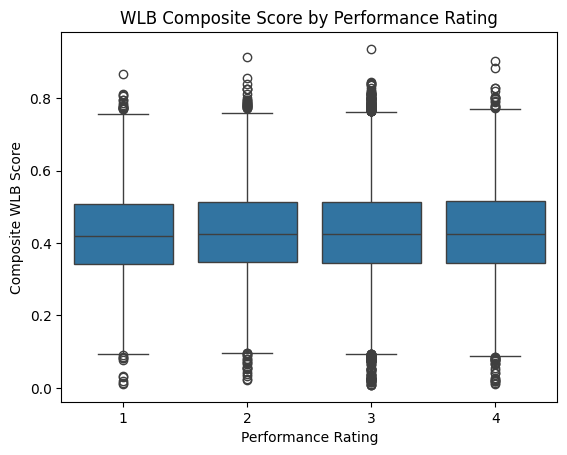

In [ ]:

# Create 'DistanceBin' based on 'Distance from Home'
bins = [0, 5, 15, df['Distance from Home'].max() + 1]
labels = ['Short', 'Medium', 'Long']
df['DistanceBin'] = pd.cut(df['Distance from Home'], bins=bins, labels=labels)

# Encode DistanceBin to numeric
df['DistanceBin_Encoded'] = df['DistanceBin'].map({'Short': 1, 'Medium': 2, 'Long': 3})

# Define WLB-related features
wlb_features = [
    'WLB_Ordinal',
    'JobSatisfaction_Ordinal',
    'IncomePerYear',
    'IncomePerDependent',
    'Overtime_and_Remote',
    'Satisfaction_Interaction',
    'DistanceBin_Encoded'
]

# Normalize and create WLB Composite
scaler = MinMaxScaler()
df['WLB_Composite'] = pd.DataFrame(scaler.fit_transform(df[wlb_features]), columns=wlb_features).mean(axis=1)

# ANOVA test
groups = [df[df['Performance Rating'] == rating]['WLB_Composite'] for rating in sorted(df['Performance Rating'].unique())]
f_stat, p_val = f_oneway(*groups)

# Output
print(" ANOVA Test for WLB Composite Score vs. Performance Rating")
print(f"F-Statistic: {f_stat:.4f}")
print(f"P-Value: {p_val:.4f}")

# Visualize
sns.boxplot(x='Performance Rating', y='WLB_Composite', data=df)
plt.title('WLB Composite Score by Performance Rating')
plt.xlabel('Performance Rating')
plt.ylabel('Composite WLB Score')
plt.show()


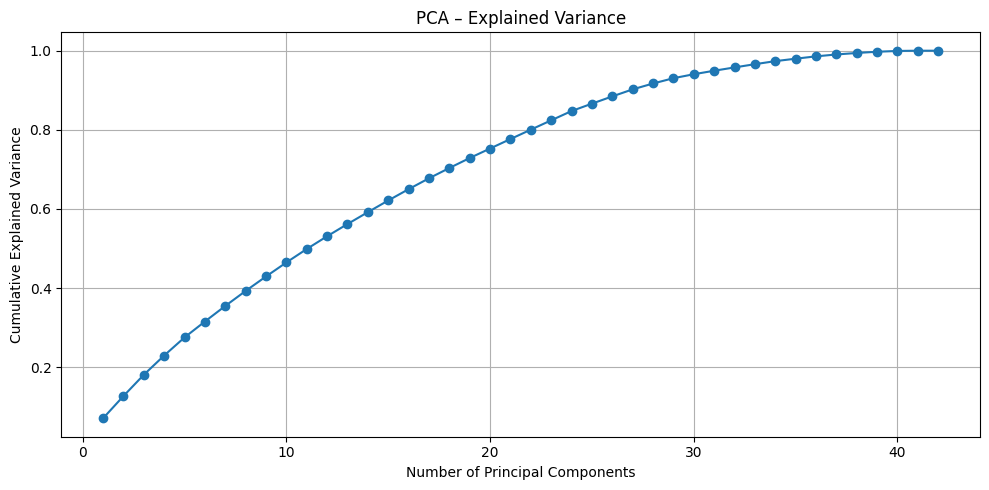

<ipython-input-6-e4173cbaa43c>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_df.head(20), x='Importance', y='Feature', palette='crest')


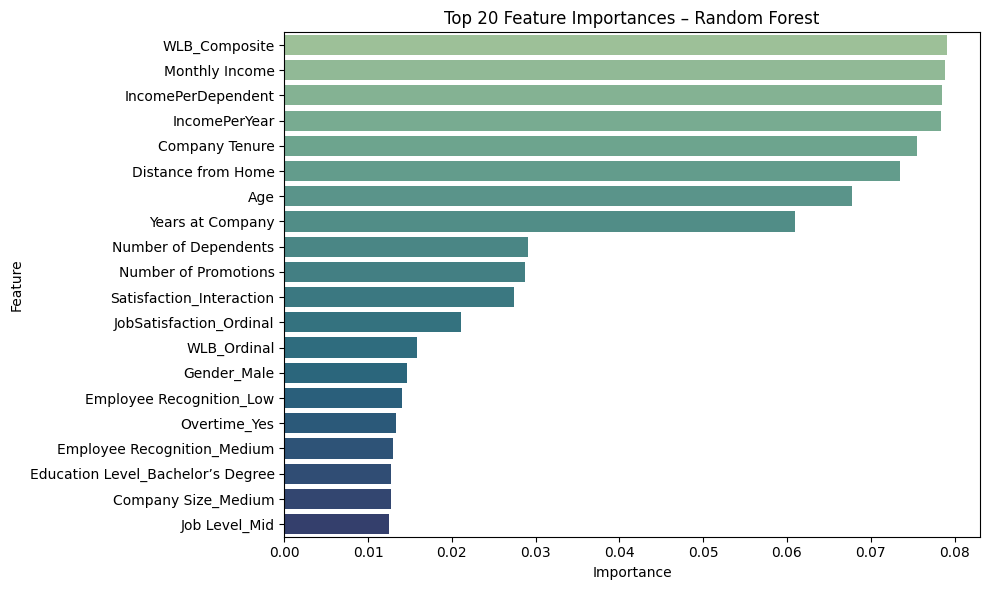

,Feature,Importance
13,WLB_Composite,0.079084
2,Monthly Income,0.078817
10,IncomePerDependent,0.078447
9,IncomePerYear,0.078339
6,Company Tenure,0.075539
4,Distance from Home,0.073487
0,Age,0.067770
1,Years at Company,0.060946
5,Number of Dependents,0.029087
3,Number of Promotions,0.028685


In [ ]:

# Prepare features and labels
X = train_df_encoded.drop(columns=["Performance Rating"])
y = train_df_encoded["Performance Rating"] - 1  # labels to 0–3

# Drop NaNs
X = X.dropna()
y = y[X.index]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot Cumulative Explained Variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA – Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

# Random Forest Feature Importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y)

importances = rf.feature_importances_
feature_names = X.columns

# Create DataFrame
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot Top 20 Features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_df.head(20), x='Importance', y='Feature', palette='crest')
plt.title("Top 20 Feature Importances – Random Forest")
plt.tight_layout()
plt.show()

# Optional: Show all feature importances
feature_df.head(20)


In [ ]:
!pip install mord

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=154adf68c8242a0190b1cbdb2ec01ca1071592bb455fe6db3b26c2c595792bb6
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


<ipython-input-11-e88a3e2c252d>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(20), y='Feature', x='Coefficient', palette='crest')


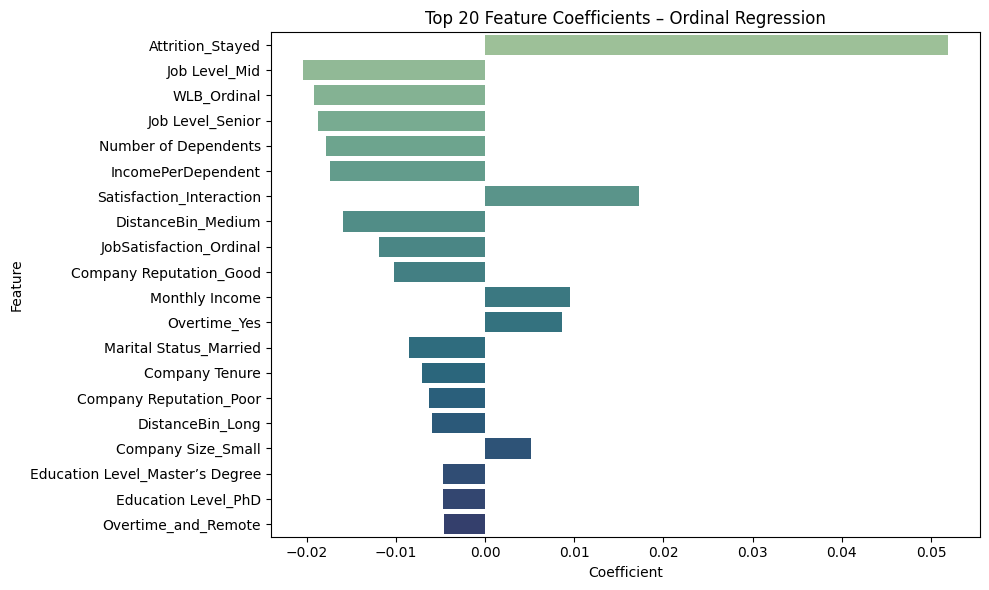

In [ ]:

# Features and Target
X = train_df_encoded.drop(columns=["Performance Rating"])
y = train_df_encoded["Performance Rating"]

# Train-test split (first, before dropping)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Drop NaNs from training set only
train_na_free = pd.concat([X_train, y_train], axis=1).dropna()
X_train_clean = train_na_free.drop(columns=["Performance Rating"])
y_train_clean = train_na_free["Performance Rating"]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)

# Fit Ordinal Ridge
ord_model = OrdinalRidge()
ord_model.fit(X_train_scaled, y_train_clean)

# Get feature coefficients
feature_importance_df = pd.DataFrame({
    'Feature': X_train_clean.columns,
    'Coefficient': ord_model.coef_.flatten()
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(20), y='Feature', x='Coefficient', palette='crest')
plt.title("Top 20 Feature Coefficients – Ordinal Regression")
plt.tight_layout()
plt.show()


📊 One-Way ANOVA Results (WLB → Job Satisfaction)

WLB_Ordinal: F = nan, p = nan
IncomePerYear: F = 0.0949, p = 0.9629
IncomePerDependent: F = 1.3119, p = 0.2685
Overtime_and_Remote: F = 2.4448, p = 0.0620
Satisfaction_Interaction: F = nan, p = nan
DistanceBin_Encoded: F = 0.6244, p = 0.5992
WLB_Composite: F = 10751.4747, p = 0.0000

📈 Spearman Correlation (WLB features vs. Job Satisfaction)

WLB_Ordinal: Spearman r = -0.0022, p = 0.5852
IncomePerYear: Spearman r = -0.0024, p = 0.5198
IncomePerDependent: Spearman r = -0.0079, p = 0.0320
Overtime_and_Remote: Spearman r = 0.0002, p = 0.9562
Satisfaction_Interaction: Spearman r = 0.6361, p = 0.0000
DistanceBin_Encoded: Spearman r = 0.0006, p = 0.8771
WLB_Composite: Spearman r = 0.5349, p = 0.0000


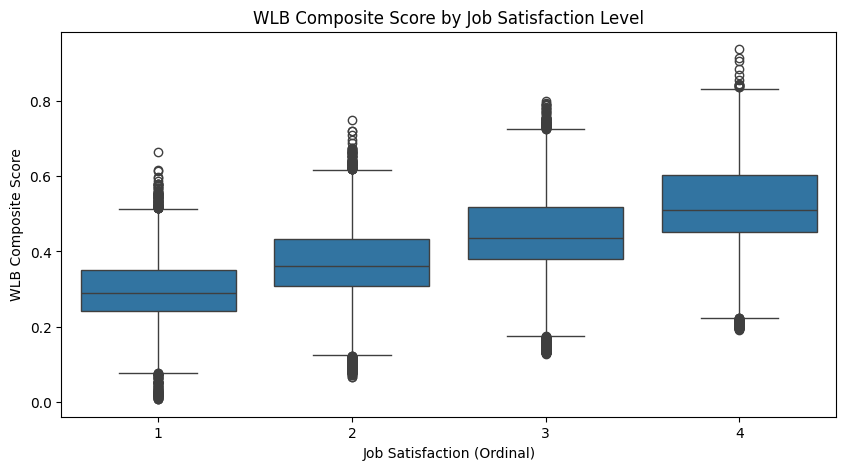

In [ ]:

# Select relevant features
wlb_related_features = [
    'WLB_Ordinal',
    'IncomePerYear',
    'IncomePerDependent',
    'Overtime_and_Remote',
    'Satisfaction_Interaction',
    'DistanceBin_Encoded',  #
    'WLB_Composite'
]


# ANOVA: Does each feature differ significantly across job satisfaction levels?
print(" One-Way ANOVA Results (WLB → Job Satisfaction)\n")
for feature in wlb_related_features:
    groups = [df[df['JobSatisfaction_Ordinal'] == level][feature]
              for level in sorted(df['JobSatisfaction_Ordinal'].dropna().unique())]
    f_stat, p_val = f_oneway(*groups)
    print(f"{feature}: F = {f_stat:.4f}, p = {p_val:.4f}")


# Spearman Correlation
print("\n Spearman Correlation (WLB features vs. Job Satisfaction)\n")
for feature in wlb_related_features:
    corr, p = spearmanr(df[feature], df['JobSatisfaction_Ordinal'], nan_policy='omit')
    print(f"{feature}: Spearman r = {corr:.4f}, p = {p:.4f}")

# Optional: Boxplot visualization
plt.figure(figsize=(10, 5))
sns.boxplot(x='JobSatisfaction_Ordinal', y='WLB_Composite', data=df)
plt.title('WLB Composite Score by Job Satisfaction Level')
plt.xlabel('Job Satisfaction (Ordinal)')
plt.ylabel('WLB Composite Score')
plt.show()


In [ ]:

# Group performance by each job satisfaction level
groups = [df[df['JobSatisfaction_Ordinal'] == level]['Performance Rating']
          for level in sorted(df['JobSatisfaction_Ordinal'].unique())]

# Run Kruskal-Wallis test
stat, p = kruskal(*groups)

print(" Kruskal-Wallis H-Test:")
print(f"H-statistic: {stat:.4f}")
print(f"P-value: {p:.4f}")


🔍 Kruskal-Wallis H-Test:
H-statistic: 0.4597
P-value: 0.9277


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:39:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:

              precision    recall  f1-score   support

           1       0.04      0.18      0.07       746
           2       0.16      0.11      0.13      2228
           3       0.60      0.20      0.29      8944
           4       0.20      0.49      0.28      2982

    accuracy                           0.24     14900
   macro avg       0.25      0.24      0.19     14900
weighted avg       0.42      0.24      0.26     14900



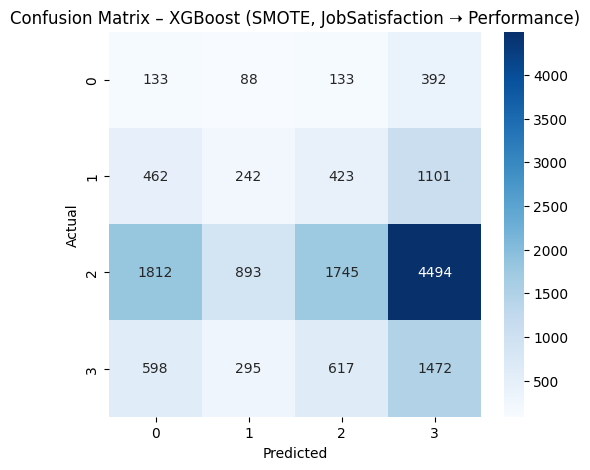

In [ ]:

# Define feature and target
X = df_encoded[['JobSatisfaction_Ordinal']]
y = df_encoded['Performance Rating'] - 1  # Convert to 0–3

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE on training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# XGBoost Training
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_train_res, y_train_res)

# Predictions
y_pred = model.predict(X_test)

#  Classification Report
print("Classification Report:\n")
print(classification_report(y_test + 1, y_pred + 1))  # back to 1–4 scale

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test + 1, y_pred + 1), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – XGBoost (SMOTE, JobSatisfaction ➝ Performance)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           1       0.05      0.70      0.09       885
           2       0.00      0.00      0.00      2685
           3       0.00      0.00      0.00     10743
           4       0.20      0.29      0.23      3567

    accuracy                           0.09     17880
   macro avg       0.06      0.25      0.08     17880
weighted avg       0.04      0.09      0.05     17880



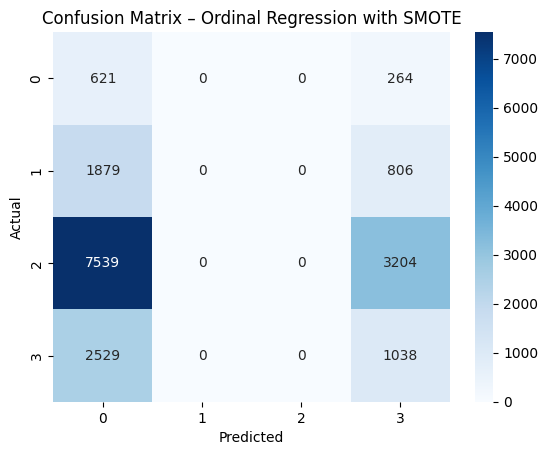

In [ ]:

# Load data
df = pd.read_csv("train.csv").dropna()

# Encode target and feature
df["Performance Rating"] = df["Performance Rating"].map({'Low': 1, 'Below Average': 2, 'Average': 3, 'High': 4})  # Make it 0–3
df["JobSatisfaction_Ordinal"] = df["Job Satisfaction"].map({'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4})

# Define X and y
X = df[["JobSatisfaction_Ordinal"]]
y = df["Performance Rating"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Train Ordinal Logistic Regression
model = LogisticIT()
model.fit(X_train_res, y_train_res)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Ordinal Regression with SMOTE")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


📊 Classification Report – XGBoost (Multivariate)
              precision    recall  f1-score   support

           1       0.05      0.23      0.08       487
           2       0.16      0.21      0.18      1477
           3       0.59      0.39      0.47      5788
           4       0.19      0.16      0.17      1953

    accuracy                           0.31      9705
   macro avg       0.25      0.25      0.23      9705
weighted avg       0.42      0.31      0.35      9705

Accuracy: 0.310252447192169


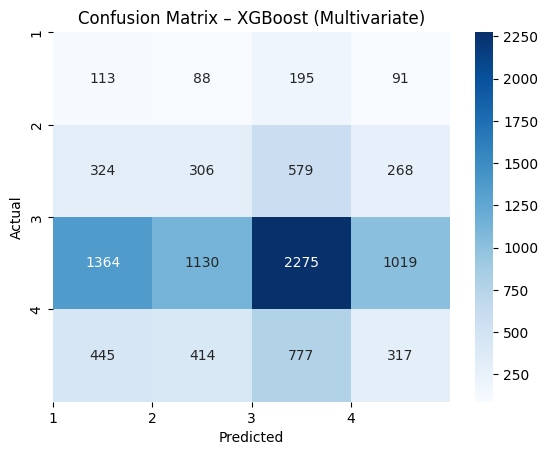

In [ ]:

# Split features and target
X = train_df_encoded[['JobSatisfaction_Ordinal', 'WLB_Composite', 'IncomePerYear', 'Overtime_and_Remote']]  # example custom selection
y = train_df_encoded["Performance Rating"] - 1  # convert 1–4 → 0–3

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Drop rows with missing values (just to be safe)
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

# Apply SMOTE to training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost
model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
model.fit(X_train_scaled, y_train_resampled)

# Predict & Evaluate
y_pred = model.predict(X_test_scaled)
y_test_actual = y_test + 1
y_pred_actual = y_pred + 1

print(" Classification Report – XGBoost (Multivariate)")
print(classification_report(y_test_actual, y_pred_actual))
print("Accuracy:", accuracy_score(y_test_actual, y_pred_actual))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_actual, y_pred_actual), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – XGBoost (Multivariate)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0,1,2,3], labels=[1,2,3,4])
plt.yticks(ticks=[0,1,2,3], labels=[1,2,3,4])
plt.show()


🔢 Class Distribution:
Performance Rating
1     2950
2     8950
3    35810
4    11888
Name: count, dtype: int64


<ipython-input-18-9c8f72602523>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='Set2')


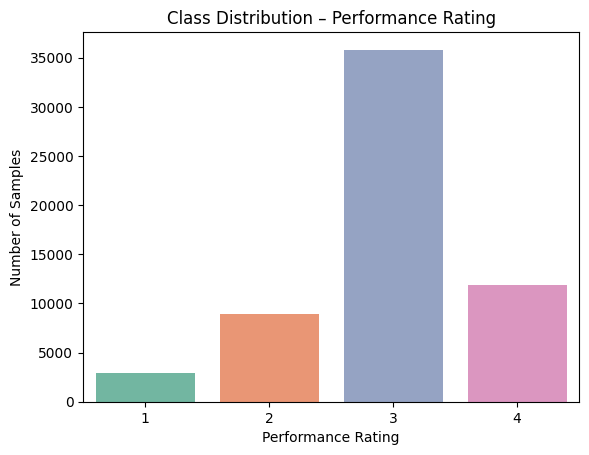

In [ ]:

# Replace with your DataFrame and target column
target_column = 'Performance Rating'  # adjust if needed
df = train_df_encoded  # or the full combined DataFrame

# Value counts
class_counts = df[target_column].value_counts().sort_index()
print(" Class Distribution:")
print(class_counts)

# Bar plot
sns.barplot(x=class_counts.index, y=class_counts.values, palette='Set2')
plt.title("Class Distribution – Performance Rating")
plt.xlabel("Performance Rating")
plt.ylabel("Number of Samples")
plt.show()


📊 ANOVA Test for WLB Composite vs. Performance Rating
F-Statistic: nan
P-Value: nan


<ipython-input-17-12cf3998740f>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Performance Rating', y='WLB_Composite', data=df, palette='Blues')


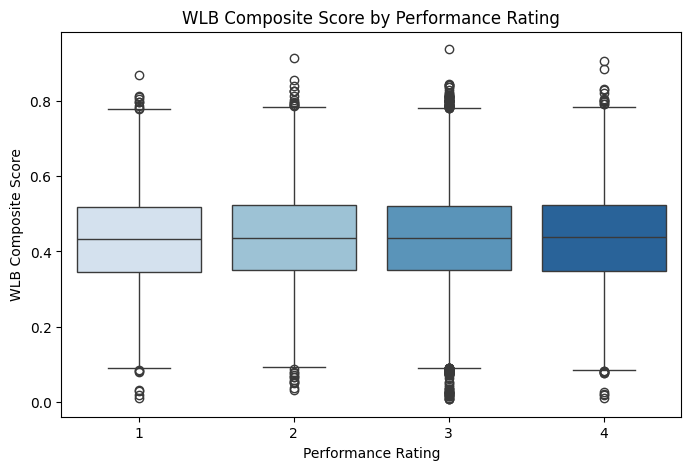

In [ ]:

# Load original datasets
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

# Add is_train flag
train['is_train'] = 1
test['is_train'] = 0

# Merge
df = pd.concat([train, test], ignore_index=True)

# Map Performance Rating to numeric
rating_map = {'Low': 1, 'Below Average': 2, 'Average': 3, 'High': 4}
df['Performance Rating'] = df['Performance Rating'].map(rating_map)

# Drop ID + handle missing
df.drop(columns=['Employee ID'], inplace=True)
df.dropna(inplace=True)

# Ordinal mappings
df['WLB_Ordinal'] = df['Work-Life Balance'].map({'Poor': 1, 'Fair': 2, 'Good': 3})
df['JobSatisfaction_Ordinal'] = df['Job Satisfaction'].map({'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4})

# Interaction & ratio features
df['IncomePerYear'] = df['Monthly Income'] / (df['Years at Company'] + 1)
df['IncomePerDependent'] = df['Monthly Income'] / (df['Number of Dependents'] + 1)
df['Overtime_and_Remote'] = ((df['Overtime'] == 'Yes') & (df['Remote Work'] == 'Yes')).astype(int)
df['Satisfaction_Interaction'] = df['WLB_Ordinal'] * df['JobSatisfaction_Ordinal']

# Encode DistanceBin
bins = [0, 5, 15, df['Distance from Home'].max()+1]
labels = ['Short', 'Medium', 'Long']
df['DistanceBin'] = pd.cut(df['Distance from Home'], bins=bins, labels=labels)
df['DistanceBin_Encoded'] = df['DistanceBin'].map({'Short': 1, 'Medium': 2, 'Long': 3})

# Final WLB features for composite
wlb_features = [
    'WLB_Ordinal',
    'JobSatisfaction_Ordinal',
    'IncomePerYear',
    'IncomePerDependent',
    'Overtime_and_Remote',
    'Satisfaction_Interaction',
    'DistanceBin_Encoded'
]

# Scale and create composite
scaler = MinMaxScaler()
df['WLB_Composite'] = scaler.fit_transform(df[wlb_features]).mean(axis=1)

# ANOVA: group by performance
groups = [df[df['Performance Rating'] == i]['WLB_Composite'] for i in sorted(df['Performance Rating'].unique())]
f_stat, p_val = f_oneway(*groups)

# Output ANOVA results
print(" ANOVA Test for WLB Composite vs. Performance Rating")
print(f"F-Statistic: {f_stat:.4f}")
print(f"P-Value: {p_val:.4f}")

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='Performance Rating', y='WLB_Composite', data=df, palette='Blues')
plt.title("WLB Composite Score by Performance Rating")
plt.xlabel("Performance Rating")
plt.ylabel("WLB Composite Score")
plt.show()


In [ ]:

# Ensure Work-Life Balance is mapped properly
wlb_map = {'Poor': 1, 'Fair': 2, 'Good': 3, 'Excellent': 4}
df['WLB_Ordinal'] = df['Work-Life Balance'].map(wlb_map)

# Drop rows with NaNs in either column
df_chi = df.dropna(subset=['WLB_Ordinal', 'Performance Rating'])

# Create contingency table
contingency_table = pd.crosstab(df_chi['WLB_Ordinal'], df_chi['Performance Rating'])

# Perform chi-square test
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

# Show results
print("Chi-Square Statistic:", chi2)
print("P-Value:", p_val)


Chi-Square Statistic: 10.87130643042798
P-Value: 0.2846335247827027


<ipython-input-14-c9f5990ac813>:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


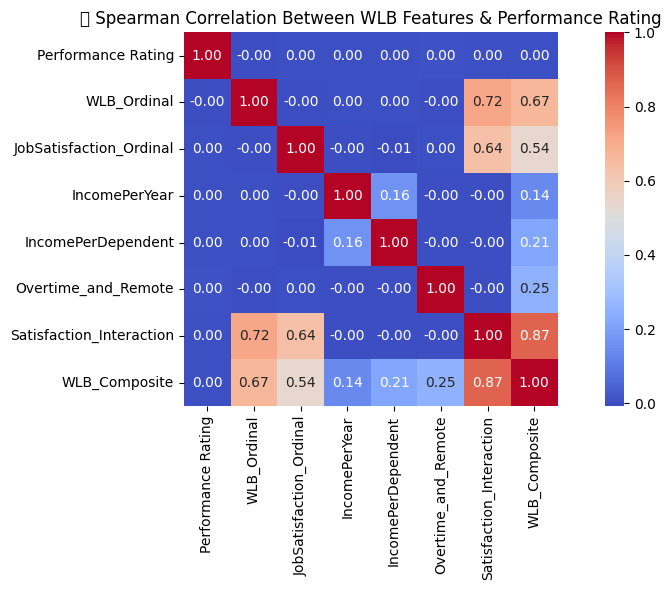

In [ ]:

# List of WLB-related features and target
wlb_corr_features = [
    'Performance Rating',
    'WLB_Ordinal',
    'JobSatisfaction_Ordinal',
    'IncomePerYear',
    'IncomePerDependent',
    'Overtime_and_Remote',
    'Satisfaction_Interaction',
    'WLB_Composite'
]

# Subset dataframe
wlb_corr_df = df[wlb_corr_features]

# Compute Spearman correlation
correlation_matrix = wlb_corr_df.corr(method='spearman')

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title(" Spearman Correlation Between WLB Features & Performance Rating")
plt.tight_layout()
plt.show()


In [ ]:

# Manually compute eta-squared from your ANOVA
ss_between = sum([len(g) * (g.mean() - df['WLB_Composite'].mean())**2 for g in groups])
ss_total = sum((df['WLB_Composite'] - df['WLB_Composite'].mean())**2)
eta_squared = ss_between / ss_total

print(f"η² (Eta-Squared): {eta_squared:.4f}")


η² (Eta-Squared): 0.0001


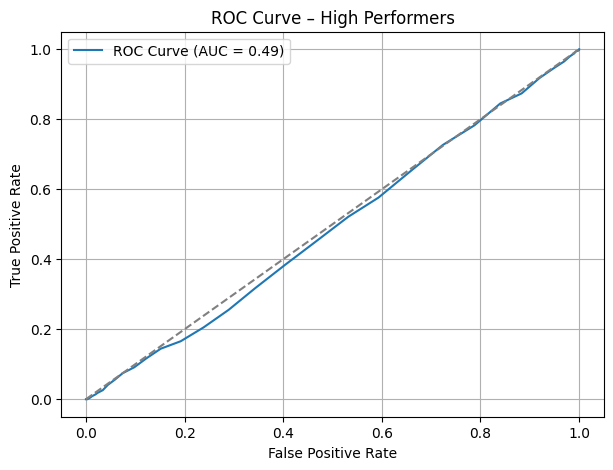

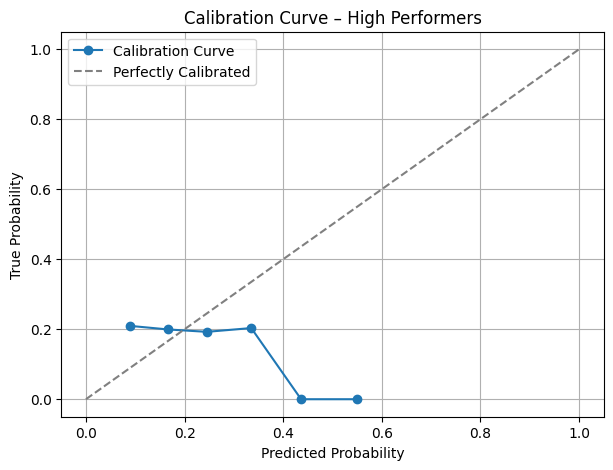

In [ ]:

# Binary Target
df_binary = df.copy()
df_binary['High_Performer'] = (df_binary['Performance Rating'] == 4).astype(int)

# Drop old target
df_binary.drop(columns=['Performance Rating'], inplace=True)

# Define X and y
X = df_binary.drop(columns=['High_Performer'])
y = df_binary['High_Performer']

# Encode all object/categorical columns
X = pd.get_dummies(X, drop_first=True)

# Drop NaNs (to ensure model stability)
X = X.dropna()
y = y.loc[X.index]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

# Probabilities for ROC & Calibration
y_probs = clf.predict_proba(X_test_scaled)[:, 1]  # probability of being class 1 (High Performer)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – High Performers")
plt.legend()
plt.grid(True)
plt.show()

# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)

plt.figure(figsize=(7,5))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve – High Performers")
plt.legend()
plt.grid(True)
plt.show()


🔍 ANOVA Test for Monthly Income vs. Performance Rating
F-Statistic: 0.9627
P-Value: 0.4092


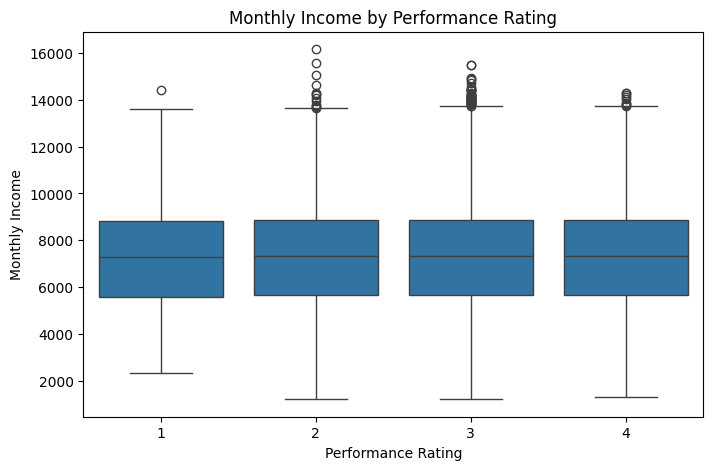

In [ ]:

# ANOVA: Test if mean income differs significantly across performance groups
groups_income = [df[df['Performance Rating'] == rating]['Monthly Income'] for rating in sorted(df['Performance Rating'].unique())]
f_stat_income, p_val_income = f_oneway(*groups_income)

print(" ANOVA Test for Monthly Income vs. Performance Rating")
print(f"F-Statistic: {f_stat_income:.4f}")
print(f"P-Value: {p_val_income:.4f}")

# Visualization: Box plot to show income distribution across ratings
plt.figure(figsize=(8, 5))
sns.boxplot(x='Performance Rating', y='Monthly Income', data=df)
plt.title('Monthly Income by Performance Rating')
plt.xlabel('Performance Rating')
plt.ylabel('Monthly Income')
plt.show()


In [ ]:

# Example: run for all numerical columns
numerical_cols = df.select_dtypes(include='number').columns
numerical_cols = [col for col in numerical_cols if col != 'Performance Rating']  # exclude target

anova_results = []

for col in numerical_cols:
    groups = [df[df['Performance Rating'] == rating][col].dropna() for rating in sorted(df['Performance Rating'].unique())]
    if len(groups) > 1:  # make sure we have at least two groups
        f_stat, p_val = f_oneway(*groups)
        anova_results.append((col, f_stat, p_val))

# Sort by F-statistic (higher means more difference between groups)
anova_df = pd.DataFrame(anova_results, columns=["Feature", "F-Statistic", "P-Value"])
anova_df = anova_df.sort_values(by="F-Statistic", ascending=False)

print(anova_df)


                     Feature  F-Statistic   P-Value
5       Number of Dependents     2.222216  0.083326
14             WLB_Composite     1.926289  0.122889
8                WLB_Ordinal     1.872634  0.131766
12       Overtime_and_Remote     1.258856  0.286632
11        IncomePerDependent     1.253817  0.288410
7                   is_train     1.207177  0.305347
3       Number of Promotions     1.138356  0.331953
4         Distance from Home     1.056246  0.366340
2             Monthly Income     0.962677  0.409219
9    JobSatisfaction_Ordinal     0.653563  0.580609
6             Company Tenure     0.543575  0.652445
13  Satisfaction_Interaction     0.406514  0.748322
10             IncomePerYear     0.236506  0.870963
1           Years at Company     0.129183  0.942802
0                        Age     0.090005  0.965565


In [ ]:

#  Load Data
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# Add train/test flag
train_df["is_train"] = 1
test_df["is_train"] = 0

# Combine
df = pd.concat([train_df, test_df], ignore_index=True)

# Map Performance Rating to numeric
rating_map = {'Low': 1, 'Below Average': 2, 'Average': 3, 'High': 4}
df['Performance Rating'] = df['Performance Rating'].map(rating_map)

# Drop ID and handle missing values
df = df.drop(columns=["Employee ID"])
df = df.dropna()

# Ordinal Encoding for WLB and Job Satisfaction
df["WLB_Ordinal"] = df["Work-Life Balance"].map({'Poor': 1, 'Fair': 2, 'Good': 3})
df["JobSatisfaction_Ordinal"] = df["Job Satisfaction"].map({'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4})

# Interaction & Ratio Features
df['IncomePerYear'] = df['Monthly Income'] / (df['Years at Company'] + 1)
df['IncomePerDependent'] = df['Monthly Income'] / (df['Number of Dependents'] + 1)
df['Overtime_and_Remote'] = ((df['Overtime'] == 'Yes') & (df['Remote Work'] == 'Yes')).astype(int)
df['Satisfaction_Interaction'] = df['WLB_Ordinal'] * df['JobSatisfaction_Ordinal']

# Binning Commute Distance
bins = [0, 5, 15, df['Distance from Home'].max() + 1]
labels = ['Short', 'Medium', 'Long']
df['DistanceBin'] = pd.cut(df['Distance from Home'], bins=bins, labels=labels)

# Drop columns already represented or engineered
df = df.drop(columns=['Work-Life Balance', 'Job Satisfaction'])

# One-Hot Encode Nominal Categorical
df_encoded = pd.get_dummies(df, drop_first=True)

#  Split Back
train_df_encoded = df_encoded[df_encoded["is_train"] == 1].drop(columns=["is_train"])
test_df_encoded = df_encoded[df_encoded["is_train"] == 0].drop(columns=["is_train"])

#Hypothesis Testing: Does WLB Affect Performance?
grouped = train_df_encoded.groupby("Performance Rating")["WLB_Ordinal"].apply(list)
f_stat, p_value = f_oneway(*grouped)

print("F-Statistic:", f_stat)
print("P-Value:", p_value)


F-Statistic: nan
P-Value: nan


In [ ]:
#train_df_encoded.groupby("Performance Rating")["WLB_Ordinal"].describe()
#train_df_encoded["Performance Rating"].value_counts()
print(train_df_encoded["WLB_Ordinal"].isna().sum())


10719


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:26:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Classification Report – XGBoost with SMOTE + Imputation
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       590
           2       0.09      0.00      0.00      1790
           3       0.60      0.99      0.75      7162
           4       0.19      0.01      0.02      2378

    accuracy                           0.60     11920
   macro avg       0.22      0.25      0.19     11920
weighted avg       0.41      0.60      0.45     11920

Accuracy: 0.5955536912751678


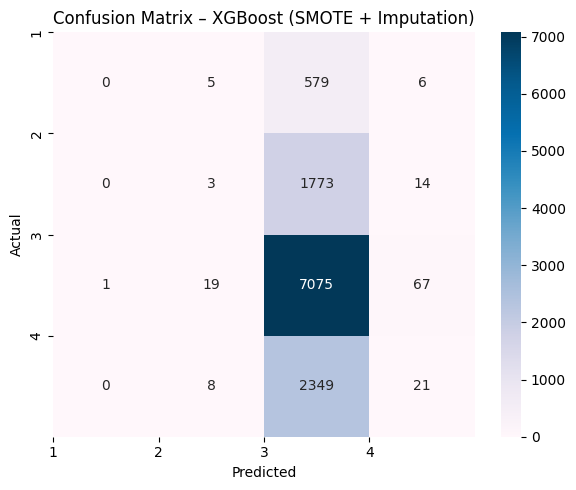

In [ ]:

# Define Features and Target
X = train_df_encoded.drop(columns=['Performance Rating'])
y = train_df_encoded['Performance Rating'] - 1  # XGBoost needs 0-based labels

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Impute missing values (IMPORTANT before SMOTE)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train_imputed, y_train)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test_imputed)

# Train the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_scaled, y_train_smote)

# Predict
y_pred = xgb_model.predict(X_test_scaled)

# Adjust prediction back to original labels (1–4)
y_test_actual = y_test + 1
y_pred_actual = y_pred + 1

# Evaluate
print(" Classification Report – XGBoost with SMOTE + Imputation")
print(classification_report(y_test_actual, y_pred_actual, zero_division=0))
print("Accuracy:", accuracy_score(y_test_actual, y_pred_actual))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test_actual, y_pred_actual), annot=True, fmt='d', cmap='PuBu')
plt.title("Confusion Matrix – XGBoost (SMOTE + Imputation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0, 1, 2, 3], labels=[1, 2, 3, 4])
plt.yticks(ticks=[0, 1, 2, 3], labels=[1, 2, 3, 4])
plt.tight_layout()
plt.show()


Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       590
           2       0.09      0.01      0.01      1790
           3       0.60      0.97      0.74      7162
           4       0.18      0.01      0.02      2378

    accuracy                           0.59     11920
   macro avg       0.22      0.25      0.19     11920
weighted avg       0.41      0.59      0.45     11920

Accuracy: 0.5880872483221476


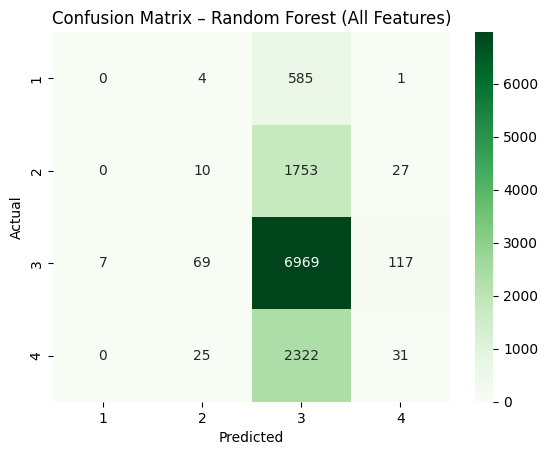

In [ ]:

# Split X and y
X = train_df_encoded.drop(columns=["Performance Rating"])
y = train_df_encoded["Performance Rating"] - 1  # convert 1–4 → 0–3 for consistency

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train = X_train.dropna()
y_train = y_train[X_train.index]

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train_res)

# Predict and Evaluate
y_pred = rf_model.predict(X_test_scaled)
y_pred_actual = y_pred + 1
y_test_actual = y_test + 1

print("Classification Report:\n", classification_report(y_test_actual, y_pred_actual))
print("Accuracy:", accuracy_score(y_test_actual, y_pred_actual))

#  Confusion Matrix
labels = sorted(np.unique(y_test_actual))
sns.heatmap(confusion_matrix(y_test_actual, y_pred_actual), annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix – Random Forest (All Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
#plt.xticks(ticks=[0, 1, 2, 3], labels=[1, 2, 3, 4])
#plt.yticks(ticks=[0, 1, 2, 3], labels=[1, 2, 3, 4])
plt.show()


<ipython-input-3-7350394e509a>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, y='Feature', x='Importance', palette='viridis')
<ipython-input-3-7350394e509a>:18: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


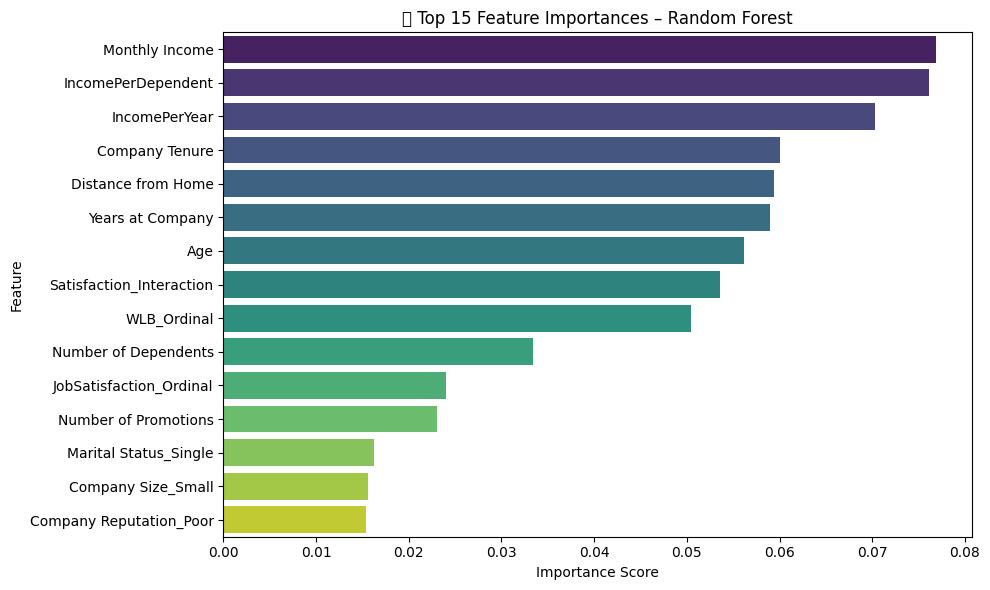

In [ ]:

# Get feature names and importances
feature_names = X.columns
importances = rf_model.feature_importances_

# Create DataFrame
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(15)  # Top 15

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df, y='Feature', x='Importance', palette='viridis')
plt.title(" Top 15 Feature Importances – Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


📊 Classification Report – Ordinal Regression
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       590
           2       0.16      0.51      0.24      1790
           3       0.62      0.54      0.57      7162
           4       0.00      0.00      0.00      2378

    accuracy                           0.40     11920
   macro avg       0.19      0.26      0.20     11920
weighted avg       0.39      0.40      0.38     11920

Accuracy: 0.3985738255033557


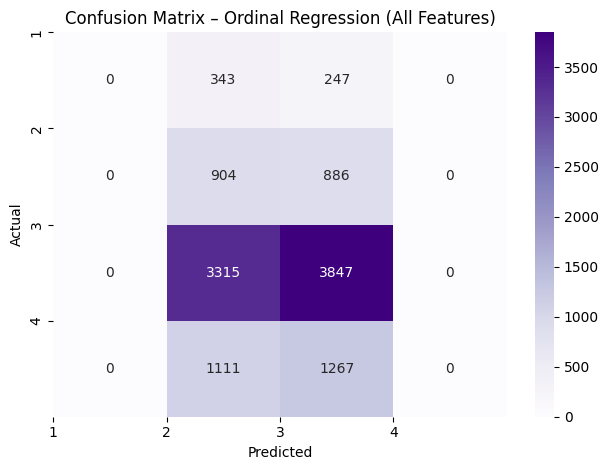

In [ ]:

# Split X and y
X = train_df_encoded.drop(columns=["Performance Rating"])
y = train_df_encoded["Performance Rating"]  # Keep as 1–4

# Impute missing values BEFORE SMOTE
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

# Train Ordinal Regression
model = OrdinalRidge()
model.fit(X_train_scaled, y_train_sm)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)

print(" Classification Report – Ordinal Regression")
print(classification_report(y_test, y_pred, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix – Ordinal Regression (All Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0, 1, 2, 3], labels=[1, 2, 3, 4])
plt.yticks(ticks=[0, 1, 2, 3], labels=[1, 2, 3, 4])
plt.tight_layout()
plt.show()


In [ ]:
pip install statsmodels


Classification Report – Random Forest (Multivariate)
              precision    recall  f1-score   support

           1       0.05      0.16      0.08       487
           2       0.15      0.22      0.18      1477
           3       0.60      0.39      0.47      5788
           4       0.20      0.24      0.22      1953

    accuracy                           0.32      9705
   macro avg       0.25      0.25      0.24      9705
weighted avg       0.42      0.32      0.36      9705

Accuracy: 0.3224111282843895


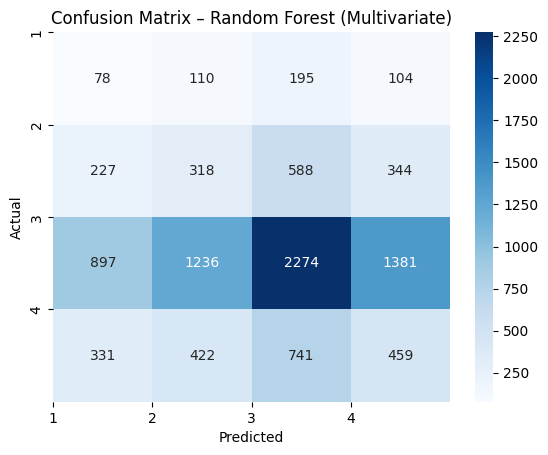

In [ ]:

# Split features and target
X = train_df_encoded[['JobSatisfaction_Ordinal', 'WLB_Composite', 'IncomePerYear', 'Overtime_and_Remote']]  # custom selection
y = train_df_encoded["Performance Rating"] - 1  # convert 1–4 → 0–3

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Drop missing values
X_train = X_train.dropna()
y_train = y_train[X_train.index]
X_test = X_test.dropna()
y_test = y_test[X_test.index]

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train_resampled)

# Predict & Evaluate
y_pred = rf_model.predict(X_test_scaled)
y_test_actual = y_test + 1
y_pred_actual = y_pred + 1

print("Classification Report – Random Forest (Multivariate)")
print(classification_report(y_test_actual, y_pred_actual))
print("Accuracy:", accuracy_score(y_test_actual, y_pred_actual))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_actual, y_pred_actual), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Random Forest (Multivariate)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0,1,2,3], labels=[1,2,3,4])
plt.yticks(ticks=[0,1,2,3], labels=[1,2,3,4])
plt.show()
